In [1]:
!pip install kaggle

In [4]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [5]:
!kaggle datasets download -d ananthu017/emotion-detection-fer

Dataset URL: https://www.kaggle.com/datasets/ananthu017/emotion-detection-fer
License(s): CC0-1.0
 68% 44.0M/65.2M [00:00<00:00, 238MB/s]
100% 65.2M/65.2M [00:00<00:00, 216MB/s]


In [6]:
!unzip "/content/emotion-detection-fer.zip" -d "/content/dataset"

Streaming output truncated to the last 5000 lines.
  inflating: /content/dataset/train/sad/im37.png  
  inflating: /content/dataset/train/sad/im370.png  
  inflating: /content/dataset/train/sad/im3700.png  
  inflating: /content/dataset/train/sad/im3701.png  
  inflating: /content/dataset/train/sad/im3702.png  
  inflating: /content/dataset/train/sad/im3703.png  
  inflating: /content/dataset/train/sad/im3704.png  
  inflating: /content/dataset/train/sad/im3705.png  
  inflating: /content/dataset/train/sad/im3706.png  
  inflating: /content/dataset/train/sad/im3707.png  
  inflating: /content/dataset/train/sad/im3708.png  
  inflating: /content/dataset/train/sad/im3709.png  
  inflating: /content/dataset/train/sad/im371.png  
  inflating: /content/dataset/train/sad/im3710.png  
  inflating: /content/dataset/train/sad/im3711.png  
  inflating: /content/dataset/train/sad/im3712.png  
  inflating: /content/dataset/train/sad/im3713.png  
  inflating: /content/dataset/train/sad/im3714.png  

In [42]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import sklearn
import cv2
from sklearn.metrics import confusion_matrix, roc_curve
import seaborn as sns
import datetime
import pathlib
import io
import os
import time
import random
from google.colab import files
from PIL import Image
import albumentations as A
import tensorflow_datasets as tfds
import tensorflow_probability as tfp
import matplotlib.cm as cm
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer
from tensorflow.keras.layers import (GlobalAveragePooling2D, Activation, MaxPooling2D, Add, Conv2D, MaxPool2D, Dense,
                                     Flatten, InputLayer, BatchNormalization, Input, Embedding, Permute,
                                     Dropout, RandomFlip, RandomRotation, LayerNormalization, MultiHeadAttention,
                                     RandomContrast, Rescaling, Resizing, Reshape)
from tensorflow.keras.losses import BinaryCrossentropy,CategoricalCrossentropy, SparseCategoricalCrossentropy
from tensorflow.keras.metrics import Accuracy,TopKCategoricalAccuracy, CategoricalAccuracy, SparseCategoricalAccuracy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import (Callback, CSVLogger, EarlyStopping, LearningRateScheduler,
                                        ModelCheckpoint, ReduceLROnPlateau)
from tensorflow.keras.regularizers  import L2, L1
from tensorflow.train import BytesList, FloatList, Int64List
from tensorflow.train import Example, Features, Feature
from google.colab import drive

In [8]:
train_directory = "/content/dataset/train"

In [10]:
validation_directory = "/content/dataset/train"

In [69]:
CLASS_NAMES =  ['angry', 'disgusted', 'fearful', 'happy', 'neutral', 'sad', 'surprised']
CONFIGURATION = {
    "BATCH_SIZE": 32,
    "IM_SIZE": 256,
    "LEARNING_RATE": 1e-3,
    "N_EPOCHS": 20,
    "DROPOUT_RATE": 0.0,
    "REGULARIZATION_RATE": 0.0,
    "N_FILTERS": 6,
    "KERNEL_SIZE": 3,
    "N_STRIDES": 1,
    "POOL_SIZE": 2,
    "N_DENSE_1": 1024,
    "N_DENSE_2": 128,
    "NUM_CLASSES": 7,
    "PATCH_SIZE": 16,
    "PROJ_DIM": 768,
}

In [34]:
train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    train_directory,
    labels='inferred',
    label_mode='categorical',
    class_names=CLASS_NAMES,
    color_mode='rgb',
    batch_size=CONFIGURATION["BATCH_SIZE"],
    image_size=(CONFIGURATION["IM_SIZE"],CONFIGURATION["IM_SIZE"]),
    shuffle=True,
    seed=42,
)

Found 28709 files belonging to 7 classes.


In [35]:
val_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    validation_directory,
    labels='inferred',
    label_mode='categorical',
    class_names=CLASS_NAMES,
    color_mode='rgb',
    batch_size=CONFIGURATION["BATCH_SIZE"],
    image_size=(CONFIGURATION["IM_SIZE"],CONFIGURATION["IM_SIZE"]),
    shuffle=True,
    seed=42,
)

Found 28709 files belonging to 7 classes.


In [22]:
for i in val_dataset.take(1):
  print(i)

(<tf.Tensor: shape=(32, 256, 256, 3), dtype=float32, numpy=
array([[[[130., 130., 130.],
         [130., 130., 130.],
         [130., 130., 130.],
         ...,
         [120., 120., 120.],
         [120., 120., 120.],
         [120., 120., 120.]],

        [[130., 130., 130.],
         [130., 130., 130.],
         [130., 130., 130.],
         ...,
         [120., 120., 120.],
         [120., 120., 120.],
         [120., 120., 120.]],

        [[130., 130., 130.],
         [130., 130., 130.],
         [130., 130., 130.],
         ...,
         [120., 120., 120.],
         [120., 120., 120.],
         [120., 120., 120.]],

        ...,

        [[184., 184., 184.],
         [184., 184., 184.],
         [184., 184., 184.],
         ...,
         [192., 192., 192.],
         [192., 192., 192.],
         [192., 192., 192.]],

        [[184., 184., 184.],
         [184., 184., 184.],
         [184., 184., 184.],
         ...,
         [192., 192., 192.],
         [192., 192., 192.],
       

Visualization

In [23]:
import matplotlib.pyplot as plt

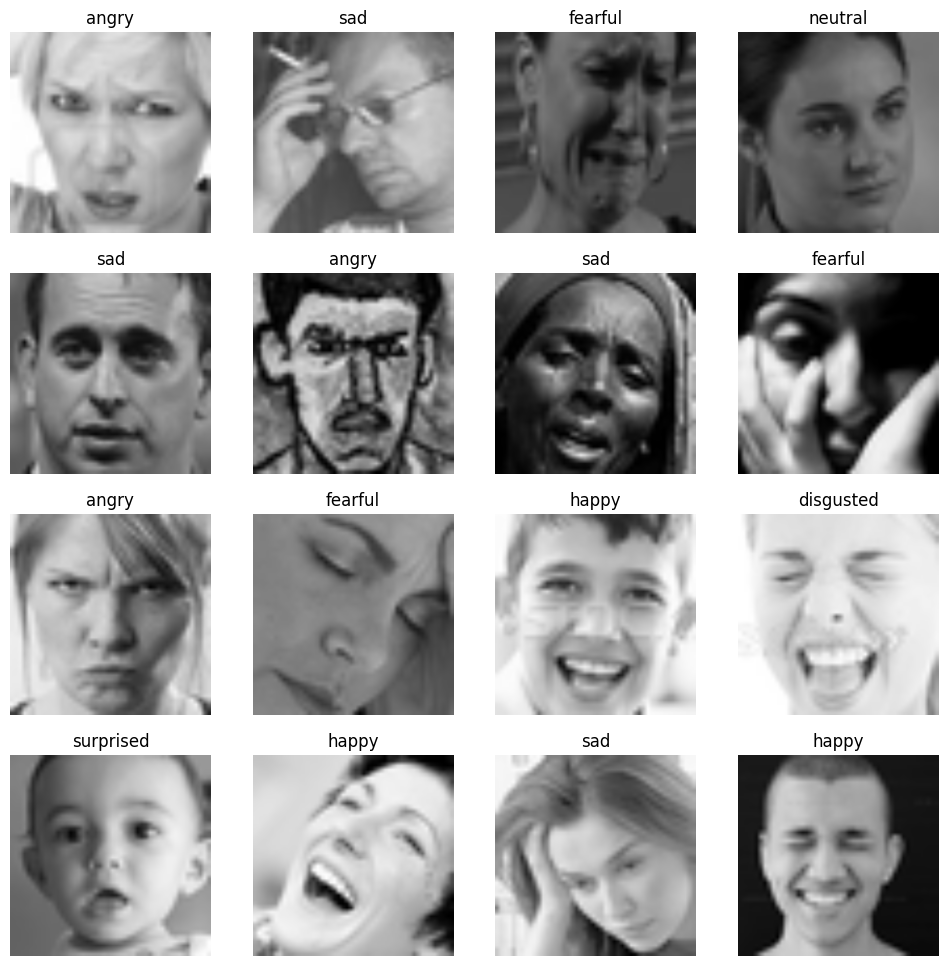

In [39]:
plt.figure(figsize = (12,12))

for images,labels in train_dataset.take(1):
  for i in range(16):
    ax = plt.subplot(4,4,i+1)
    plt.imshow(images[i]/255.)
    label_index = tf.argmax(labels[i],axis=0).numpy()
    ax.set_title(CLASS_NAMES[label_index])
    plt.axis('off')
  plt.show()

In [25]:
training_dataset = {
    train_dataset.prefetch(tf.data.AUTOTUNE)
}

In [79]:
validation_dataset = (
    val_dataset
    .prefetch(tf.data.AUTOTUNE)
)

In [43]:
resize_rescale_layers = tf.keras.Sequential([
    tf.keras.layers.Resizing(CONFIGURATION["IM_SIZE"],CONFIGURATION["IM_SIZE"]),
    tf.keras.layers.Rescaling(1./255)
])

In [44]:
lenet_model = tf.keras.Sequential(
    [
    InputLayer(input_shape = (None, None, 3), ),

    resize_rescale_layers,

    Conv2D(filters = CONFIGURATION["N_FILTERS"] , kernel_size = CONFIGURATION["KERNEL_SIZE"], strides = CONFIGURATION["N_STRIDES"] , padding='valid',
          activation = 'relu',kernel_regularizer = L2(CONFIGURATION["REGULARIZATION_RATE"])),
    BatchNormalization(),
    MaxPool2D (pool_size = CONFIGURATION["POOL_SIZE"], strides= CONFIGURATION["N_STRIDES"]*2),
    Dropout(rate = CONFIGURATION["DROPOUT_RATE"] ),

    Conv2D(filters = CONFIGURATION["N_FILTERS"]*2 + 4, kernel_size = CONFIGURATION["KERNEL_SIZE"], strides=CONFIGURATION["N_STRIDES"], padding='valid',
          activation = 'relu', kernel_regularizer = L2(CONFIGURATION["REGULARIZATION_RATE"])),
    BatchNormalization(),
    MaxPool2D (pool_size = CONFIGURATION["POOL_SIZE"], strides= CONFIGURATION["N_STRIDES"]*2),

    Flatten(),

    Dense( CONFIGURATION["N_DENSE_1"], activation = "relu", kernel_regularizer = L2(CONFIGURATION["REGULARIZATION_RATE"])),
    BatchNormalization(),
    Dropout(rate = CONFIGURATION["DROPOUT_RATE"]),

    Dense( CONFIGURATION['N_DENSE_2'], activation = "relu", kernel_regularizer = L2(CONFIGURATION["REGULARIZATION_RATE"])),
    BatchNormalization(),

    Dense(CONFIGURATION["NUM_CLASSES"], activation = "softmax"),

])

lenet_model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential_2 (Sequential)            │ (None, 256, 256, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 254, 254, 6)         │             168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 254, 254, 6)         │              24 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 127, 127, 6)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 127, 127, 6)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 125, 125, 16)        │             880 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 125, 125, 16)        │              64 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 62, 62, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 61504)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1024)                │      62,981,120 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 1024)                │           4,096 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 128)                 │         131,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 7)                   │             903 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 63,118,967 (240.78 MB)

 Trainable params: 63,116,619 (240.77 MB)

 Non-trainable params: 2,348 (9.17 KB)

In [45]:
loss_function = CategoricalCrossentropy()

In [46]:
metrics = [CategoricalAccuracy(name = "accuracy"),TopKCategoricalAccuracy(k=2,name = 'top_k_accuracy')]

In [47]:
lenet_model.compile(
    optimizer = Adam(learning_rate = CONFIGURATION["LEARNING_RATE"]),
    loss = loss_function,
    metrics = metrics
)

In [48]:
history = lenet_model.fit(
    train_dataset,
    validation_data = val_dataset,
    epochs = CONFIGURATION["N_EPOCHS"],
)

Epoch 1/20
898/898 ━━━━━━━━━━━━━━━━━━━━ 89s 87ms/step - accuracy: 0.3055 - loss: 1.8293 - top_k_accuracy: 0.4971 - val_accuracy: 0.2161 - val_loss: 2.2374 - val_top_k_accuracy: 0.3968
Epoch 2/20
898/898 ━━━━━━━━━━━━━━━━━━━━ 57s 63ms/step - accuracy: 0.4377 - loss: 1.4741 - top_k_accuracy: 0.6297 - val_accuracy: 0.5532 - val_loss: 1.2098 - val_top_k_accuracy: 0.7381
Epoch 3/20
898/898 ━━━━━━━━━━━━━━━━━━━━ 56s 63ms/step - accuracy: 0.5319 - loss: 1.2554 - top_k_accuracy: 0.7219 - val_accuracy: 0.4491 - val_loss: 1.8745 - val_top_k_accuracy: 0.6486
Epoch 4/20
898/898 ━━━━━━━━━━━━━━━━━━━━ 57s 63ms/step - accuracy: 0.6171 - loss: 1.0416 - top_k_accuracy: 0.7952 - val_accuracy: 0.7428 - val_loss: 0.7314 - val_top_k_accuracy: 0.8845
Epoch 5/20
898/898 ━━━━━━━━━━━━━━━━━━━━ 57s 64ms/step - accuracy: 0.7429 - loss: 0.7027 - top_k_accuracy: 0.8906 - val_accuracy: 0.7524 - val_loss: 0.6866 - val_top_k_accuracy: 0.8997
Epoch 6/20
898/898 ━━━━━━━━━━━━━━━━━━━━ 81s 63ms/step - accuracy: 0.8510 - loss:

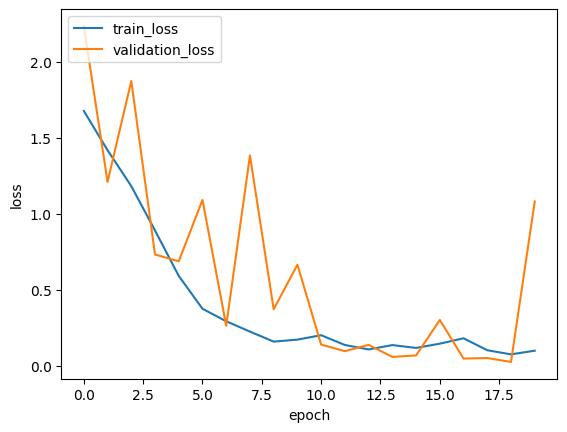

In [58]:
import matplotlib
plt.title = matplotlib.pyplot.title
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
# plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train_loss', 'validation_loss'], loc='upper left')
plt.show()


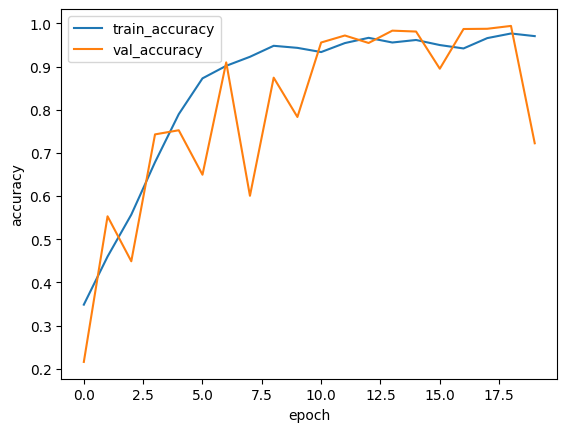

In [57]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
# plt.title('Model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train_accuracy', 'val_accuracy'])
plt.show()

In [66]:
validation_dataset

{<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 7), dtype=tf.float32, name=None))>}

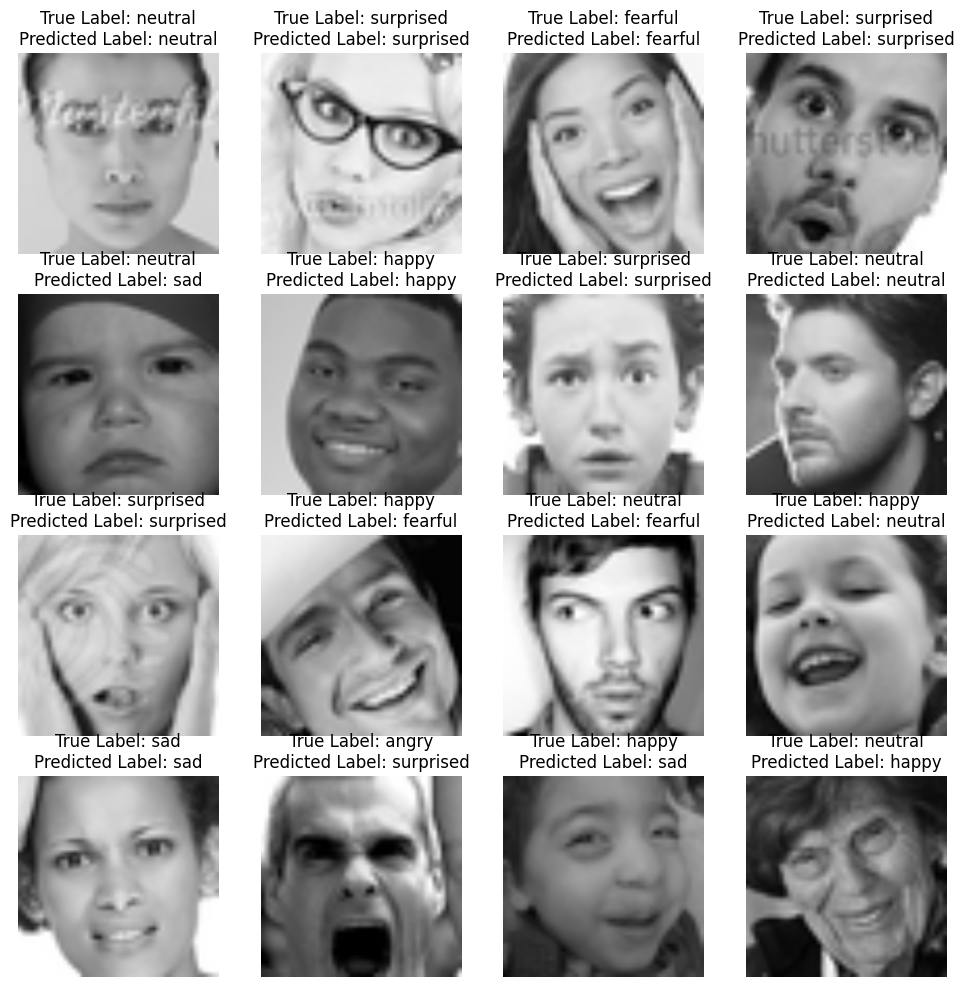

In [82]:
plt.figure(figsize = (12,12))

# for images, labels in val_dataset.take(1):
#   for i in range(16):
#     ax = plt.subplot(4,4, i+1)
#     plt.imshow(images[i]/255.)
#     plt.title("True Label - : " + CLASS_NAMES[tf.argmax(labels[i], axis = 0).numpy()]
#               + "\n" + "Predicted Label - : "
#               + CLASS_NAMES[tf.argmax(lenet_model[i], axis =-1).numpy()[0]] )
#     plt.axis("off")


for images, labels in val_dataset.take(1):
    for i in range(16):
        ax = plt.subplot(4, 4, i + 1)
        plt.imshow(images[i] / 255.)
        true_label = CLASS_NAMES[tf.argmax(labels[i], axis=0).numpy()]
        predicted_label = CLASS_NAMES[tf.argmax(lenet_model(tf.expand_dims(images[i], axis=0)), axis=-1).numpy()[0]]
        ax.set_title(f"True Label: {true_label}\nPredicted Label: {predicted_label}")
        ax.axis('off')

plt.show()